# Adapted from [fastai](https://github.com/fastai/course22p2/blob/master/nbs/01_matmul.ipynb)

## Matrix multiplication from foundations

The *foundations* we'll assume throughout this course are:

- Python
- matplotlib
- The Python standard library
- Jupyter notebooks and nbdev

In [1]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

## Get data

In [2]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

[urlretrieve](https://docs.python.org/3/library/urllib.request.html#urllib.request.urlretrieve) - (read the docs!)

In [3]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [4]:
# urlretrieve?
# urlretrieve??

In [5]:
!ls -l data

total 16656
-rw-r--r-- 1 root root 17051982 Sep  7 02:29 mnist.pkl.gz


In [6]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [7]:
lst1 = list(x_train[0])
vals = lst1[200:210]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

In [8]:
len(lst1)

784

In [9]:
def chunks(x, sz):
    for i in range(0, len(x), sz): yield x[i:i+sz]

In [10]:
len(vals)

10

In [11]:
val_iter = chunks(vals, 5)
next(val_iter)

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

In [12]:
next(val_iter)

[0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]

In [14]:
next(val_iter)

StopIteration: 

In [15]:
list(chunks(vals, 5))

[[0.0, 0.0, 0.0, 0.19140625, 0.9296875],
 [0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]]

In [16]:
chunks(vals, 5)

<generator object chunks at 0x7e95f47a45f0>

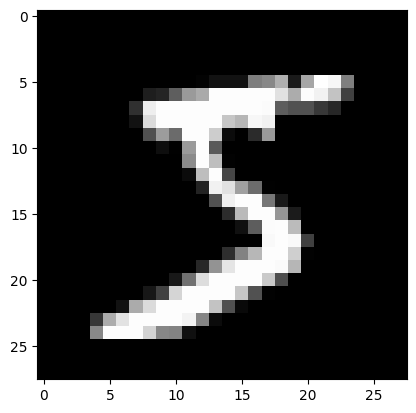

In [17]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(lst1, 28)));

[islice](https://docs.python.org/3/library/itertools.html#itertools.islice)

In [18]:
from itertools import islice

In [19]:
it = iter(vals)
islice(it, 5)

In [20]:
for i in iter(vals):
  print(i)

0.0
0.0
0.0
0.19140625
0.9296875
0.98828125
0.98828125
0.98828125
0.98828125
0.98828125


In [21]:
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

In [22]:
list(islice(it, 5))

[0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]

In [23]:
list(islice(it, 5))

[]

In [24]:
it = iter(lst1)
img = list(iter(lambda: list(islice(it, 28)), []))

In [25]:
def f(): return list(islice(it, 28))

In [26]:
# iter?

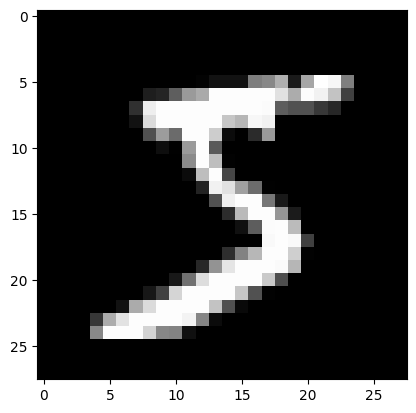

In [27]:
plt.imshow(img);

## Matrix and tensor

In [28]:
img[20][15]

0.98828125

In [29]:
class Matrix:
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

In [30]:
m = Matrix(img)
m[20,15]

0.98828125

In [31]:
import torch
from torch import tensor

In [32]:
tensor([1,2,3])

tensor([1, 2, 3])

In [33]:
tens = tensor(img)
tens[20,15]

tensor(0.9883)

In [34]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape

torch.Size([50000, 784])

In [35]:
x_train.type()

'torch.FloatTensor'

[Tensor](https://pytorch.org/docs/stable/tensors.html)

In [36]:
imgs = x_train.reshape((-1,28,28))
imgs.shape

torch.Size([50000, 28, 28])

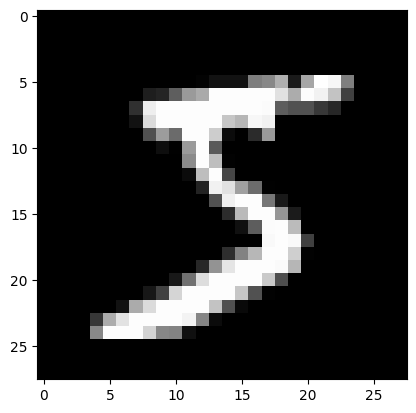

In [37]:
plt.imshow(imgs[0]);

In [38]:
imgs[0,20,15]

tensor(0.9883)

In [39]:
n,c = x_train.shape
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

In [40]:
y_train[:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [41]:
imgs[:10].shape

torch.Size([10, 28, 28])

In [42]:
min(y_train),max(y_train)

(tensor(0), tensor(9))

In [43]:
y_train.min(), y_train.max()

(tensor(0), tensor(9))

## Matrix multiplication

In [44]:
torch.manual_seed(1)
weights = torch.randn(784,10)
bias = torch.zeros(10)

In [45]:
weights[:10]

tensor([[-1.5256, -0.7502, -0.6540, -1.6095, -0.1002, -0.6092, -0.9798, -1.6091,
         -0.7121,  0.3037],
        [-0.7773, -0.2515, -0.2223,  1.6871,  0.2284,  0.4676, -0.6970, -1.1608,
          0.6995,  0.1991],
        [ 0.8657,  0.2444, -0.6629,  0.8073,  1.1017, -0.1759, -2.2456, -1.4465,
          0.0612, -0.6177],
        [-0.7981, -0.1316,  1.8793, -0.0721,  0.1578, -0.7735,  0.1991,  0.0457,
          0.1530, -0.4757],
        [-0.1110,  0.2927, -0.1578, -0.0288,  2.3571, -1.0373,  1.5748, -0.6298,
         -0.9274,  0.5451],
        [ 0.0663, -0.4370,  0.7626,  0.4415,  1.1651,  2.0154,  0.1374,  0.9386,
         -0.1860, -0.6446],
        [ 1.5392, -0.8696, -3.3312, -0.7479, -0.0255, -1.0233, -0.5962, -1.0055,
         -0.2106, -0.0075],
        [ 1.6734,  0.0103, -0.7040, -0.1853, -0.9962, -0.8313, -0.4610, -0.5601,
          0.3956, -0.9823],
        [-0.5065,  0.0998, -0.6540,  0.7317, -1.4344, -0.5008,  0.1716, -0.1600,
          0.2546, -0.5020],
        [-1.0412,  

In [46]:
m1 = x_valid[:5]
m2 = weights

In [47]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [48]:
ar,ac = m1.shape # n_rows * n_cols
br,bc = m2.shape
(ar,ac),(br,bc)

((5, 784), (784, 10))

In [49]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

In [50]:
for i in range(ar):         # 5
    for j in range(bc):     # 10
        for k in range(ac): # 784
            t1[i,j] += m1[i,k] * m2[k,j]

In [51]:
t1

tensor([[-10.9417,  -0.6844,  -7.0038,  -4.0066,  -2.0857,  -3.3588,   3.9127,
          -3.4375, -11.4696,  -2.1153],
        [ 14.5430,   5.9977,   2.8914,  -4.0777,   6.5914, -14.7383,  -9.2787,
           2.1577, -15.2772,  -2.6758],
        [  2.2204,  -3.2171,  -4.7988,  -6.0453,  14.1661,  -8.9824,  -4.7922,
          -5.4446, -20.6758,  13.5657],
        [ -6.7097,   8.8998,  -7.4611,  -7.8966,   2.6994,  -4.7260, -11.0278,
         -12.9776,  -6.4443,   3.6376],
        [ -2.4444,  -6.4034,  -2.3984,  -9.0371,  11.1772,  -5.7724,  -8.9214,
          -3.7862,  -8.9827,   5.2797]])

In [52]:
t1.shape

torch.Size([5, 10])

In [53]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [54]:
import numpy as np
np.set_printoptions(precision=2, linewidth=140)

In [55]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): c[i,j] += a[i,k] * b[k,j]
    return c

In [56]:
%time _=matmul(m1, m2)

CPU times: user 817 ms, sys: 5.08 ms, total: 822 ms
Wall time: 828 ms


In [57]:
ar*bc*ac

39200

## Numba

In [58]:
from numba import njit

In [59]:
@njit
def dot(a,b):
    res = 0.
    for i in range(len(a)): res+=a[i]*b[i]
    return res

In [60]:
from numpy import array

In [61]:
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 621 ms, sys: 32.7 ms, total: 653 ms
Wall time: 651 ms


20.0

In [62]:
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 25 µs, sys: 3 µs, total: 28 µs
Wall time: 31.5 µs


20.0

Now only two of our loops are running in Python, not three:

In [63]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = dot(a[i,:], b[:,j])
    return c

In [64]:
m1a,m2a = m1.numpy(),m2.numpy()

In [65]:
from fastcore.test import *

In [66]:
test_close(t1,matmul(m1a, m2a))

In [67]:
%timeit -n 50 matmul(m1a,m2a)

718 µs ± 71.2 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Elementwise ops

[TryAPL](https://tryapl.org/)

In [68]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [69]:
a + b

tensor([12., 14.,  3.])

In [70]:
(a < b)

tensor([False,  True,  True])

In [71]:
(a < b).float().mean()

tensor(0.67)

In [72]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Frobenius norm:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

*Hint*: you don't normally need to write equations in LaTeX yourself, instead, you can click 'edit' in Wikipedia and copy the LaTeX from there (which is what I did for the above equation). Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in `.tgz` if it doesn't already, and you should find the source there, including the equations to copy and paste. This is the source LaTeX that I pasted to render the equation above:

```latex
$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$
```

In [73]:
sf = (m*m).sum()
sf

tensor(285.)

In [74]:
sf.sqrt()

tensor(16.88)

In [75]:
m[2,:],m[:,2]

(tensor([7., 8., 9.]), tensor([3., 6., 9.]))

In [76]:
m[2]

tensor([7., 8., 9.])

In [77]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [78]:
test_close(t1,matmul(m1, m2))

In [79]:
%timeit -n 50 _=matmul(m1, m2)

2.13 ms ± 182 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [80]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = torch.dot(a[i,:], b[:,j])
    return c

In [81]:
test_close(t1,matmul(m1, m2))

In [82]:
%timeit -n 50 _=matmul(m1, m2)

1.69 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with
    different shapes during arithmetic operations. Subject to certain
    constraints, the smaller array is “broadcast” across the larger
    array so that they have compatible shapes. Broadcasting provides a
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

### Broadcasting with a scalar

In [83]:
a

tensor([10.,  6., -4.])

In [84]:
a > 0

tensor([ True,  True, False])

How are we able to do `a > 0`?  0 is being **broadcast** to have the same dimensions as a.

For instance you can normalize our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar), using broadcasting.

Other examples of broadcasting with a scalar:

In [85]:
a + 1

tensor([11.,  7., -3.])

In [86]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [87]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

### Broadcasting a vector to a matrix

Although broadcasting a scalar is an idea that dates back to APL, the more powerful idea of broadcasting across higher rank tensors [comes from](https://mail.python.org/pipermail/matrix-sig/1995-November/000143.html) a little known language called [Yorick](https://software.llnl.gov/yorick-doc/manual/yorick_50.html).

We can also broadcast a vector to a matrix:

In [88]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [89]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [90]:
m.shape,c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [91]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [92]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [93]:
t = c.expand_as(m)

In [94]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [95]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

We don't really copy the rows, but it looks as if we did. In fact, the rows are given a *stride* of 0.

In [96]:
t.storage()

<ipython-input-96-9fabd8d8a8f0>:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  t.storage()


 10.0
 20.0
 30.0
[torch.storage.TypedStorage(dtype=torch.float32, device=cpu) of size 3]

In [97]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

You can index with the special value [None] or use `unsqueeze()` to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

In [98]:
 c.unsqueeze(0), c[None, :]

(tensor([[10., 20., 30.]]), tensor([[10., 20., 30.]]))

In [99]:
c.shape, c.unsqueeze(0).shape

(torch.Size([3]), torch.Size([1, 3]))

In [100]:
c.unsqueeze(1), c[:, None]

(tensor([[10.],
         [20.],
         [30.]]),
 tensor([[10.],
         [20.],
         [30.]]))

In [101]:
c.shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([3, 1]))

You can always skip trailling ':'s. And '...' means '*all preceding dimensions*'

In [102]:
c[None].shape,c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [103]:
c[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [104]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [105]:
m + c[None,:]

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

### Broadcasting Rules

In [106]:
c[None,:]

tensor([[10., 20., 30.]])

In [107]:
c[None,:].shape

torch.Size([1, 3])

In [108]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

In [109]:
c[:,None].shape

torch.Size([3, 1])

In [110]:
c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [111]:
c[None] > c[:,None]

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

In [112]:
m*m

tensor([[ 1.,  4.,  9.],
        [16., 25., 36.],
        [49., 64., 81.]])

In [113]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

## Matmul with broadcasting

In [114]:
digit = m1[0]
digit.shape,m2.shape

(torch.Size([784]), torch.Size([784, 10]))

In [115]:
digit[:,None].shape

torch.Size([784, 1])

In [116]:
digit[:,None]

tensor([[0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        

In [117]:
digit[:,None].expand_as(m2).shape

torch.Size([784, 10])

In [118]:
(digit[:,None]*m2).shape

torch.Size([784, 10])

In [119]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
#       c[i,j] = (a[i,:] * b[:,j]).sum()      # previous version
        c[i]   = (a[i,:,None] * b).sum(dim=0) # broadcast version
    return c

# line-by-line analysis

In [120]:
(ar,ac),(br,bc) = m1.shape,m2.shape
c = torch.zeros(ar, bc)
m1.shape, m2.shape, c.shape

(torch.Size([5, 784]), torch.Size([784, 10]), torch.Size([5, 10]))

In [121]:
i = 0
print(a[i,None].shape)

torch.Size([1])


In [122]:
test_close(t1,matmul(m1, m2))

In [123]:
%timeit -n 50 _=matmul(m1, m2)

238 µs ± 74.6 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


Our time has gone from ~500ms to <0.1ms, an over 5000x improvement! We can run on the whole dataset now.

In [124]:
tr = matmul(x_train, weights)
tr

tensor([[  0.96,  -2.96,  -2.11,  ..., -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79,  ..., -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,  ...,  -6.73,  -6.79,  -1.58],
        ...,
        [  7.40,   7.64,  -3.50,  ...,  -1.02, -16.22,   2.07],
        [  3.25,   9.52,  -9.37,  ...,   2.98, -19.58,  -1.96],
        [ 15.70,   4.12,  -5.62,  ...,   8.08, -12.21,   0.42]])

In [125]:
tr.shape

torch.Size([50000, 10])

In [126]:
x_train.shape, weights.shape

(torch.Size([50000, 784]), torch.Size([784, 10]))

In [127]:
%time _=matmul(x_train, weights)

CPU times: user 1.37 s, sys: 8.9 ms, total: 1.37 s
Wall time: 1.38 s


## pytorch op

We can use pytorch's function or operator directly for matrix multiplication.

In [128]:
test_close(tr, x_train@weights, eps=1e-3)

In [129]:
%timeit -n 5 _=torch.matmul(x_train, weights)

22.5 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## CUDA

In [130]:
def matmul(grid, a,b,c):
    i,j = grid
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

In [131]:
res = torch.zeros(ar, bc)
matmul((0,0), m1, m2, res)
res

tensor([[-10.94,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00]])

In [132]:
def launch_kernel(kernel, grid_x, grid_y, *args, **kwargs):
    for i in range(grid_x):
        for j in range(grid_y): kernel((i,j), *args, **kwargs)

In [133]:
res = torch.zeros(ar, bc)
launch_kernel(matmul, ar, bc, m1, m2, res)
res

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [134]:
from numba import cuda

In [135]:
def matmul(grid, a,b,c):
    i,j = grid
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

In [136]:
@cuda.jit
def matmul(a,b,c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

In [137]:
r = np.zeros(tr.shape)
m1g,m2g,rg = map(cuda.to_device, (x_train,weights,r))

In [138]:
r.shape

(50000, 10)

In [139]:
TPB = 16
rr,rc = r.shape
blockspergrid = (math.ceil(rr / TPB), math.ceil(rc / TPB))
blockspergrid

(3125, 1)

In [140]:
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()
test_close(tr, r, eps=1e-3)

In [141]:
%%timeit -n 10
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()

10.9 ms ± 3.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [142]:
m1c,m2c = x_train.cuda(),weights.cuda()

In [143]:
r=(m1c@m2c).cpu()

In [144]:
%timeit -n 10 r=(m1c@m2c).cpu()

2.05 ms ± 328 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Our broadcasting version was >500ms, and our CUDA version is around 0.5ms, which is another 1000x improvement compared to broadcasting. So our total speedup is around 5 million times!